# LeNet-5-Quantized

In this notebook, i want to demonstrate how i built LeNet-5 in PyTorch and Quantize it for visualization.



![alt text](https://miro.medium.com/max/2625/1*1TI1aGBZ4dybR6__DI9dzA.png)


# Requirments


*   PyTorch (torch)
*   torchvision
*   numpy
*   pillow (PIL)



In [1]:
%pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets
from PIL import Image
from torchsummary import summary

# MNIST Dataset

We will download the dataset with `torchvision` and add to it some transforms like padding so the size of the input images become 32x32.

We then split the data to `train_data` and `test_data` randomly.

We make another split in the training data for validation purposes using `SubsetRandomSampler`.



In [4]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
#  validation sample
valid_sample = 0.2

transform = [transforms.Pad(2), transforms.ToTensor()]

# choose the training and test datasets
train_data = datasets.MNIST(root='data',
                            train=True,
                            download=True,
                            transform=transforms.Compose(transform))
test_data = datasets.MNIST(root='data',
                           train=False,
                           download=True,
                           transform=transforms.Compose(transform))

# Creating validation sampler
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(valid_sample * num_train)
train_idx, valid_idx = indices[split:], indices[:split]

# define sampler for batches
trainSampler = SubsetRandomSampler(train_idx)
validationSampler = SubsetRandomSampler(valid_idx)

# prepare data loaders
train_loader = DataLoader(train_data,
                          batch_size=batch_size,
                          sampler=trainSampler,
                          num_workers=num_workers)
validation_loader = DataLoader(train_data,
                               batch_size=batch_size,
                               sampler=validationSampler,
                               num_workers=num_workers)
test_loader = DataLoader(test_data,
                         batch_size=batch_size,
                         num_workers=num_workers)


In [61]:
print(test_loader.dataset.data.shape)

torch.Size([10000, 28, 28])


# LeNet-5 Network

We inherited form `nn.Module` to construct the LeNet-5 architecture in two steps


1.   initialization of layers in `__init__`
2.   connecting layers to build the pipeline of the network in `forward`



In [6]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 32 x 32 x 1
        self.conv1 = nn.Conv2d(1, 6, (5, 5), padding=0, stride=1)
        # 28 x 28 x 6
        self.pool1 = nn.MaxPool2d((2, 2), stride=2)
        # 14 x 14 x 6
        self.conv2 = nn.Conv2d(6, 16, (5, 5), padding=0, stride=1)
        # 10 x 10 x 16
        self.pool2 = nn.MaxPool2d((2, 2), stride=2)
        # 5 x 5 x 16
        self.conv3 = nn.Conv2d(16, 120, (5, 5), padding=0, stride=1)
        # 1 x 1 x 120
        self.fc1 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        # Choose either view or flatten (as you like)
        x = x.view(x.size(0), -1)
        # x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = torch.softmax(self.fc2(x), dim=-1)
        return x
      
model = LeNet()
model = model.cuda()
print(model)
summary(model, input_size=(1, 32, 32))

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Conv2d-5            [-1, 120, 1, 1]          48,120
            Linear-6                   [-1, 84]          1

# Configurations

Here, we configure the loss function to be `CrossEntropyLoss` and the optimizer to be Stochastic Gradient Descent (`SGD`).

In [7]:
# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Number of epochs
n_epochs = 30

# classes of MNIST
classes = list(range(10))


# Training & Validation

We first check if a GPU is available so i can transfer the learning to it then,  we put the model in training mode and after every epoch we put the model to `eval` mode so we check the validataion loss is getting better or not to save it in `model.pt`.

In [8]:

# Choosing the device for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Training Device: {}".format(device))

model.to(device)

valid_loss_min = np.Inf

for epoch in range(n_epochs):

    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0

    ###################
    # train the model #
    ###################
    model.train()  # prep model for training
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data.to(device))
        # calculate the loss
        loss = criterion(output, target.to(device))
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item() * data.size(0)

    model.eval()
    for data, target in validation_loader:
        output = model(data.to(device))
        loss = criterion(output, target.to(device))
        valid_loss += loss.item() * data.size(0)

    # print training statistics
    # calculate average loss over an epoch
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(validation_loader.sampler)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.
          format(epoch + 1, train_loss, valid_loss))
    if valid_loss <= valid_loss_min:
        print(
            'Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'
            .format(valid_loss_min, valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss


Training Device: cuda:0
Epoch: 1 	Training Loss: 2.302373 	Validation Loss: 2.301855
Validation loss decreased (inf --> 2.301855).  Saving model ...
Epoch: 2 	Training Loss: 2.301555 	Validation Loss: 2.300633
Validation loss decreased (2.301855 --> 2.300633).  Saving model ...
Epoch: 3 	Training Loss: 2.298975 	Validation Loss: 2.294879
Validation loss decreased (2.300633 --> 2.294879).  Saving model ...
Epoch: 4 	Training Loss: 2.135713 	Validation Loss: 1.827089
Validation loss decreased (2.294879 --> 1.827089).  Saving model ...
Epoch: 5 	Training Loss: 1.690489 	Validation Loss: 1.654045
Validation loss decreased (1.827089 --> 1.654045).  Saving model ...
Epoch: 6 	Training Loss: 1.617555 	Validation Loss: 1.567997
Validation loss decreased (1.654045 --> 1.567997).  Saving model ...
Epoch: 7 	Training Loss: 1.550550 	Validation Loss: 1.538410
Validation loss decreased (1.567997 --> 1.538410).  Saving model ...
Epoch: 8 	Training Loss: 1.528745 	Validation Loss: 1.527669
Validation

# Testing

Going through the testing dataset to get the accuracy of the model.

In [9]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model = LeNet()
model.load_state_dict(torch.load("model.pt"))
model.eval()  # prep model for *evaluation*

# Choosing the device for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Testing Device: {}".format(device))

model.to(device)

# Disabling the gradient calculations for faster inference
with torch.no_grad():

  for data, target in test_loader:
      # forward pass: compute predicted outputs by passing inputs to the model
      output = model(data.to(device))
      # calculate the loss
      loss = criterion(output, target.to(device))
      # update test loss
      test_loss += loss.item() * data.size(0)
      # convert output probabilities to predicted class
      _, pred = torch.max(output, 1)
      # compare predictions to true label
      correct = np.squeeze(pred.eq(target.to(device).data.view_as(pred)))
      # calculate test accuracy for each object class
      for i in range(batch_size):
          label = target.data[i]
          class_correct[label] += correct[i].item()
          class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss / len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' %
              (str(i), 100 * class_correct[i] / class_total[i],
               np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' %
              (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' %
      (100. * np.sum(class_correct) / np.sum(class_total),
       np.sum(class_correct), np.sum(class_total)))


Testing Device: cuda:0
Test Loss: 1.478657

Test Accuracy of     0: 99% (973/980)
Test Accuracy of     1: 99% (1131/1135)
Test Accuracy of     2: 98% (1013/1032)
Test Accuracy of     3: 98% (997/1010)
Test Accuracy of     4: 98% (970/982)
Test Accuracy of     5: 97% (867/892)
Test Accuracy of     6: 98% (939/958)
Test Accuracy of     7: 97% (1007/1028)
Test Accuracy of     8: 98% (956/974)
Test Accuracy of     9: 97% (979/1009)

Test Accuracy (Overall): 98% (9832/10000)


# Quantization

We deliver a visual representation to the feature maps generated from the learnt weights.

In [54]:

def quantize_arr(arr):
    ''' Quantization based on linear rescaling over min/max range.'''
    min_val, max_val = np.min(arr), np.max(arr)

    if max_val - min_val > 0:
        quantized = np.round(255 * (arr - min_val) / (max_val - min_val))
    else:
        quantized = np.zeros(arr.shape)

    quantized = quantized.astype(np.uint8)
    min_val = min_val.astype(np.float32)
    max_val = max_val.astype(np.float32)

    return quantized, min_val, max_val

# example = np.random.randn(5, 5)
# print(example)
# quant, min_val, max_val = quantize_arr(example)
# print("\n{}, Min_Val: {}, Max_Val: {}".format(quant, min_val, max_val))  
    


# Network Analysis
We will go through every layer and print its weights (if any) and the feature maps (outputs).

torch.Size([6, 1, 5, 5])
torch.Size([6])
torch.Size([16, 6, 5, 5])
torch.Size([16])
torch.Size([120, 16, 5, 5])
torch.Size([120])
torch.Size([84, 120])
torch.Size([84])
torch.Size([10, 84])
torch.Size([10])
input_img_dataset_shape =  torch.Size([28, 28])
input_img_shape_squeezed =  torch.Size([32, 32])
input_img_shape_unsqueezed =  torch.Size([1, 1, 32, 32])
input_img_dataset_shape_unsqueezed =  torch.Size([1, 1, 28, 28])


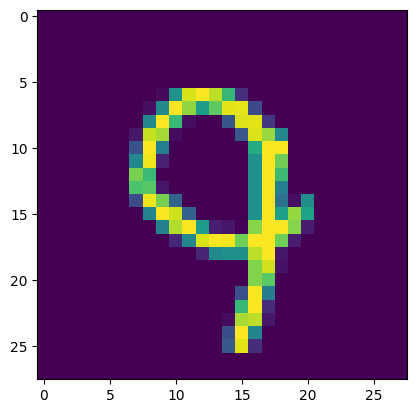

In [81]:
import matplotlib.pyplot as plt
%matplotlib inline

# Moving the model back to the CPU
model.to("cpu")

# parameters of the trained network
param = list(model.parameters())
for paramater in model.parameters():
  print(paramater.shape)
  
  
# Input image for analysis
input_img = next(iter(test_loader))[0][19].squeeze(0)
# input_img = next(iter(test_loader))[0][19].squeeze(0)
input_img_dataset = test_loader.dataset.data[999].squeeze(0)
print('input_img_dataset_shape = ',input_img_dataset.shape)
print('input_img_shape_squeezed = ',input_img.shape)
plt.imshow(input_img_dataset)

# plt.imshow(input_img)
# print('input_img_shape = ',input_img.shape)
# Modifying the input image for analysis
input_img = input_img.unsqueeze(0).unsqueeze(0)
print('input_img_shape_unsqueezed = ',input_img.shape)
# savemat('input_img.mat', {'input_img':input_img})
# files.download('input_img.mat')

# Modifying the input image_dataset for analysis
input_img_dataset = input_img_dataset.unsqueeze(0).unsqueeze(0)
print('input_img_dataset_shape_unsqueezed = ',input_img_dataset.shape)

## Custom code for multiple images

torch.Size([6, 1, 5, 5])
torch.Size([6])
torch.Size([16, 6, 5, 5])
torch.Size([16])
torch.Size([120, 16, 5, 5])
torch.Size([120])
torch.Size([84, 120])
torch.Size([84])
torch.Size([10, 84])
torch.Size([10])
[[[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0.

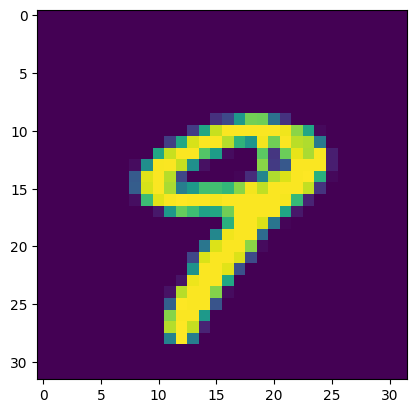

In [78]:
from scipy.io import savemat, loadmat
import matplotlib.pyplot as plt
%matplotlib inline

# Moving the model back to the CPU
model.to("cpu")

# parameters of the trained network
param = list(model.parameters())
for paramater in model.parameters():
  print(paramater.shape)
  
for k in range (0,10):
   
    # Input image for analysis
    # input_img_dataset = test_loader.dataset.data[k].squeeze(0)
    input_img = next(iter(test_loader))[0][k].squeeze(0)
    plt.imshow(input_img)
    # plt.imshow(input_img_dataset)
    
    # Modifying the input image for analysis
    input_img = input_img.unsqueeze(0).unsqueeze(0)
    # savemat('input_img.mat', {'input_img':input_img})
    # files.download('input_img.mat')
    temp_2 = input_img.detach().numpy()
    print(temp_2)
    print(temp_2.squeeze(0).squeeze(0))
    input_image = temp_2.squeeze(0).squeeze(0)
    # print(input_image.shape)
    # plt.imshow(input_image)
    # savemat(f'input_image_{k}.mat',{'input_image_{k}':input_image})
    # plt.figure(figsize=(10, 10))
    # row = 2
    # columns = 3
    # for i in range(6):
    #     output_fm = model.conv1.forward(input_img)[0][i].detach().numpy()
    # savemat(f'output_fm_conv{k}.mat', {f'output_fm_conv{k}':output_fm})

    # plt.figure(figsize=(10, 10))
    # row = 2
    # columns = 3
    # for i in range(6):
    #     output, min_val, max_val = quantize_arr(
    #         model.conv1.forward(input_img)[0][i].detach().numpy())
    #     plt.subplot(6 / columns + 1, columns, i + 1)
    #     plt.imshow(output)
    # savemat(f'quantized_output_conv{k}.mat', {f'quantized_output_conv{k}':output})
    weights = []
    bias = []
    for i in range(6):
        # print("{}, Bias: {}\n".format(param[0][i].data, param[1][i]))
        # print("Min: {}, Max: {}\n".format(np.min(param[0][i].data.numpy()), np.max(param[0][i].data.numpy())))
        w = param[0][i].data.detach().numpy()
        # print(w.shape)
        w = w.squeeze(0)
        # print(w.shape)
        # print(w)
        name = 'W'+str(i)+'_L1'
        # print(name)
        # savemat(name+'.mat', {name:w})
    param = list(model.parameters())
    # plt.figure(figsize=(5, 5))
    # row = 2
    # columns = 3
    for i in range(6):
        output, min_val, max_val = quantize_arr(
            model.pool1.forward(
                model.conv1.forward(input_img))[0][i].detach().numpy())
        # plt.subplot(6 / columns + 1, columns, i + 1)
        # plt.imshow(output)
    savemat(f'output_fm_pool_{k}.mat', {f'output_fm_pool_{k}':output})
    # # files.download('output_fm_pool1.mat')
    # plt.figure(figsize=(5, 5))
    # row = 4
    # columns = 4
    # for i in range(16):
    #     output, min_val, max_val = quantize_arr(
    #         model.conv2.forward(
    #             model.pool1.forward(
    #                 model.conv1.forward(input_img)))[0][i].detach().numpy())
    #     # plt.subplot(16 / columns + 1, columns, i + 1)
    #     # plt.imshow(output)
    # savemat('output_fm_conv2.mat', {'output_fm_conv2':output})
    # weights = []
    # bias = []
    # for i in range(16):
    # print("{}, Bias: {}\n".format(param[2][i].data, param[3][i]))
    # print("Min: {}, Max: {}\n".format(np.min(param[2][i].data.numpy()), np.max(param[2][i].data.numpy())))
    # w = param[2][i].data.detach().numpy()
    # print(w.shape)
    # # w = w.squeeze(0)
    # # print(w.shape)
    # print(w)
    # name = 'W'+str(i)+'_L2'
    # print(name)
    # savemat(name+'.mat', {name:w})
    # plt.figure(figsize=(5, 5))
    # row = 4
    # columns = 4
    # for i in range(16):
    #     output, min_val, max_val = quantize_arr(
    #         model.pool2.forward(
    #             model.conv2.forward(
    #                 model.pool1.forward(
    #                     model.conv1.forward(input_img))))[0][i].detach().numpy())
    #     # plt.subplot(16 / columns + 1, columns, i + 1)
    #     # plt.imshow(output)
    # savemat('output_fm_pool2.mat', {'output_fm_pool2':output})

## Actual Code Continuation

In [12]:
from scipy.io import savemat, loadmat
# from google.colab import files

In [ ]:
temp_2 = input_img.detach().numpy()
print(temp_2)
print(temp_2.squeeze(0).squeeze(0))
input_image = temp_2.squeeze(0).squeeze(0)
# print(input_image.shape)
plt.imshow(input_image)
savemat('input_image.mat',{'input_image':input_image})
# files.download('input_image.mat')

In [15]:
# from google.colab import files
from scipy.io import loadmat, savemat
import matplotlib.pyplot as plt
%matplotlib inline

## Conv1 Feature Maps

In [17]:
plt.figure(figsize=(10, 10))
row = 2
columns = 3
for i in range(6):
    output_fm = model.conv1.forward(input_img)[0][i].detach().numpy()
    # plt.subplot(6 / columns + 1, columns, i + 1)
    # plt.imshow(output_fm)

<Figure size 1000x1000 with 0 Axes>

In [18]:
savemat('output_fm_conv1.mat', {'output_fm_conv1':output_fm})
# files.download('output_fm_conv1.mat')

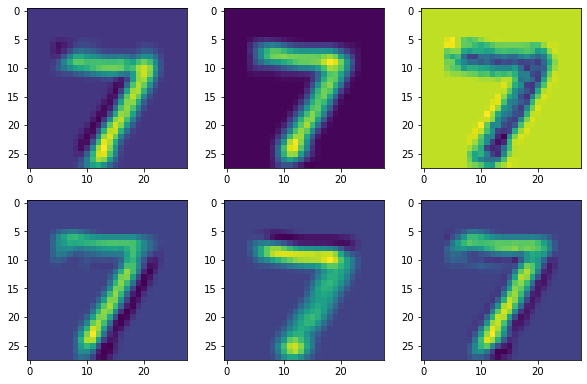

In [ ]:
plt.figure(figsize=(10, 10))
row = 2
columns = 3
for i in range(6):
    output, min_val, max_val = quantize_arr(
        model.conv1.forward(input_img)[0][i].detach().numpy())
    plt.subplot(6 / columns + 1, columns, i + 1)
    plt.imshow(output)

In [19]:
# print(output)
savemat('quantized_output_conv1.mat', {'quantized_output_conv1':output})
# files.download('quantized_output_conv1.mat')

## Conv1 Weights

In [21]:
weights = []
bias = []
for i in range(6):
  print("{}, Bias: {}\n".format(param[0][i].data, param[1][i]))
  print("Min: {}, Max: {}\n".format(np.min(param[0][i].data.numpy()), np.max(param[0][i].data.numpy())))
  w = param[0][i].data.detach().numpy()
  print(w.shape)
  w = w.squeeze(0)
  print(w.shape)
  print(w)
  name = 'W'+str(i)+'_L1'
  print(name)
  savemat(name+'.mat', {name:w})
  # files.download(name+'.mat')


tensor([[[ 0.2241,  0.2537,  0.1794,  0.4105,  0.3177],
         [ 0.1983,  0.1926,  0.3365,  0.4138,  0.1698],
         [ 0.3286,  0.1442,  0.2814,  0.4636,  0.4046],
         [ 0.1659,  0.0420,  0.2664,  0.6235,  0.2881],
         [-0.0075,  0.3358,  0.3689,  0.5362,  0.0632]]]), Bias: -0.001140353619121015

Min: -0.007527650333940983, Max: 0.623502790927887

(1, 5, 5)
(5, 5)
[[ 0.22409236  0.2537354   0.17935835  0.4104921   0.31769785]
 [ 0.19830747  0.19261603  0.336454    0.41378614  0.16980879]
 [ 0.32861882  0.14424479  0.28141585  0.4636249   0.40461507]
 [ 0.1659238   0.04203725  0.26640666  0.6235028   0.28806424]
 [-0.00752765  0.3358362   0.36891252  0.53624636  0.06322745]]
W0_L1
tensor([[[-0.0157, -0.0567,  0.0204,  0.1229, -0.0361],
         [-0.1081, -0.0728, -0.1465,  0.2755,  0.2881],
         [-0.0426, -0.0375,  0.0265, -0.0389,  0.2433],
         [-0.2110, -0.1709,  0.1631,  0.1330,  0.2957],
         [-0.1599, -0.1581,  0.2365,  0.0957,  0.1916]]]), Bias: -0.06147

## Pool1 Feature Maps

In [23]:
param = list(model.parameters())
plt.figure(figsize=(5, 5))
row = 2
columns = 3
for i in range(6):
    output, min_val, max_val = quantize_arr(
        model.pool1.forward(
            model.conv1.forward(input_img))[0][i].detach().numpy())
    # plt.subplot(6 / columns + 1, columns, i + 1)
    # plt.imshow(output)
savemat('output_fm_pool1.mat', {'output_fm_pool1':output})
# files.download('output_fm_pool1.mat')

<Figure size 500x500 with 0 Axes>

## Conv2 Feature Maps

In [25]:
plt.figure(figsize=(5, 5))
row = 4
columns = 4
for i in range(16):
    output, min_val, max_val = quantize_arr(
        model.conv2.forward(
            model.pool1.forward(
                model.conv1.forward(input_img)))[0][i].detach().numpy())
    # plt.subplot(16 / columns + 1, columns, i + 1)
    # plt.imshow(output)
savemat('output_fm_conv2.mat', {'output_fm_conv2':output})
# files.download('output_fm_conv2.mat')

<Figure size 500x500 with 0 Axes>

## Conv2 Weights

In [26]:
weights = []
bias = []
for i in range(16):
  print("{}, Bias: {}\n".format(param[2][i].data, param[3][i]))
  print("Min: {}, Max: {}\n".format(np.min(param[2][i].data.numpy()), np.max(param[2][i].data.numpy())))
  w = param[2][i].data.detach().numpy()
  print(w.shape)
  # w = w.squeeze(0)
  # print(w.shape)
  print(w)
  name = 'W'+str(i)+'_L2'
  print(name)
  savemat(name+'.mat', {name:w})
  # files.download(name+'.mat')

tensor([[[-4.1928e-02, -1.9983e-02,  5.2704e-03,  4.5462e-02, -3.4989e-03],
         [ 7.6779e-02, -9.3044e-02, -1.6613e-01, -1.6831e-01, -7.3157e-02],
         [ 2.9668e-02,  3.5822e-02,  2.1312e-02, -4.3023e-02, -1.2411e-01],
         [-3.4525e-02,  5.2974e-02,  1.0882e-01,  9.5675e-02, -1.3968e-02],
         [-1.3725e-01,  1.5080e-02,  1.7035e-01,  7.6752e-02,  8.9958e-02]],

        [[-3.8529e-02, -7.5511e-02,  9.7604e-04,  5.9771e-05,  5.7480e-02],
         [ 2.0672e-02,  1.0733e-02, -6.6874e-03, -8.7857e-02, -3.3609e-02],
         [ 4.9309e-02,  5.9050e-02, -1.1296e-01, -8.5582e-02,  3.3117e-02],
         [ 6.8425e-02,  1.8424e-02, -3.5921e-02,  4.0809e-02,  3.4147e-02],
         [ 1.8305e-02,  1.8172e-02,  2.9034e-02, -5.4455e-02, -3.2412e-02]],

        [[-1.5269e-02, -4.3412e-02,  7.6299e-02,  7.7237e-02, -2.3559e-03],
         [-5.4776e-02, -3.4652e-04,  5.1349e-02,  8.2158e-04,  9.3218e-03],
         [ 7.8105e-02, -2.6735e-02, -8.7950e-02, -3.2916e-04,  5.1412e-02],
        

## Pool2 Feature Maps

In [27]:
plt.figure(figsize=(5, 5))
row = 4
columns = 4
for i in range(16):
    output, min_val, max_val = quantize_arr(
        model.pool2.forward(
            model.conv2.forward(
                model.pool1.forward(
                    model.conv1.forward(input_img))))[0][i].detach().numpy())
    # plt.subplot(16 / columns + 1, columns, i + 1)
    # plt.imshow(output)
savemat('output_fm_pool2.mat', {'output_fm_pool2':output})
# files.download('output_fm_pool2.mat')

<Figure size 500x500 with 0 Axes>

## Conv3 Outputs

In [28]:
param = list(model.parameters())

for i in range(120):
    output = model.conv3.forward(
        model.pool2.forward(
            model.conv2.forward(
                model.pool1.forward(
                    model.conv1.forward(input_img)))))[0][i].detach().numpy()
    print(output)
savemat('output_fm_conv3.mat', {'output_fm_conv3':output})
# files.download('output_fm_conv3.mat')

[[-2.2207513]]
[[-2.901612]]
[[-2.9768045]]
[[6.2704153]]
[[11.035242]]
[[-3.54441]]
[[-2.6590025]]
[[4.2381115]]
[[6.2159915]]
[[-2.1207783]]
[[-3.396203]]
[[-4.2761545]]
[[1.8230298]]
[[11.808644]]
[[6.1390524]]
[[7.8365803]]
[[-1.1707153]]
[[-3.7208774]]
[[1.630077]]
[[-8.47728]]
[[0.9343314]]
[[3.356025]]
[[-6.0375776]]
[[6.3050303]]
[[-3.435852]]
[[-4.6040897]]
[[-1.719854]]
[[13.082316]]
[[3.0329144]]
[[-3.6761544]]
[[7.0784817]]
[[-11.106671]]
[[7.505099]]
[[5.667589]]
[[0.8364224]]
[[-3.73747]]
[[-2.6158862]]
[[7.696514]]
[[1.8699205]]
[[16.843376]]
[[4.3564415]]
[[-0.65476197]]
[[-1.4224292]]
[[-4.776389]]
[[-5.265299]]
[[0.8537346]]
[[-5.713826]]
[[2.3252876]]
[[2.4860387]]
[[-4.0677285]]
[[-8.213248]]
[[-2.6966696]]
[[7.7050943]]
[[-6.3998675]]
[[3.7759318]]
[[-0.54716104]]
[[-4.1355386]]
[[17.619205]]
[[-1.055031]]
[[-9.590618]]
[[0.29673502]]
[[0.6219769]]
[[-0.78216726]]
[[-6.9734707]]
[[-2.831233]]
[[3.2833009]]
[[17.111248]]
[[1.1879617]]
[[-5.1337376]]
[[7.6485634]]
[[

## Conv3 Weights

In [29]:
for i in range(120):
  print("{}, Bias: {}\n".format(param[4][i].data, param[5][i]))
  print("Min: {}, Max: {}\n".format(np.min(param[4][i].data.numpy()), np.max(param[4][i].data.numpy())))
  w = param[4][i].data.detach().numpy()
  # print(w.shape)
  # w = w.squeeze(0)
  # print(w.shape)
  print(w)
  name = 'W'+str(i)+'_L3'
  print(name)
  savemat(name+'.mat', {name:w})
  # files.download(name+'.mat')

tensor([[[ 0.0109, -0.0376, -0.0556,  0.0267,  0.0094],
         [ 0.0508,  0.0204,  0.0242,  0.0309,  0.0391],
         [ 0.0492, -0.0294,  0.0369, -0.0057,  0.0228],
         [ 0.0155,  0.0495, -0.0355, -0.0170, -0.0218],
         [-0.0251,  0.0266, -0.0445, -0.0449, -0.0350]],

        [[-0.0290,  0.0043, -0.0083,  0.0363,  0.0197],
         [ 0.0367, -0.0272, -0.0261,  0.0249,  0.0406],
         [-0.0245,  0.0407,  0.0471,  0.0301, -0.0268],
         [-0.0094,  0.0442,  0.0533,  0.0061,  0.0300],
         [ 0.0417,  0.0280, -0.0155, -0.0366,  0.0154]],

        [[-0.0457,  0.0265, -0.0240, -0.0013, -0.0353],
         [ 0.0400, -0.0113,  0.0269,  0.0113,  0.0132],
         [ 0.0515, -0.0308,  0.0253,  0.0338, -0.0381],
         [-0.0031,  0.0279, -0.0161, -0.0110, -0.0232],
         [-0.0013, -0.0207, -0.0469, -0.0294,  0.0166]],

        [[-0.0365,  0.0079, -0.0223,  0.0329,  0.0044],
         [ 0.0387,  0.0403, -0.0277,  0.0285,  0.0191],
         [ 0.0357,  0.0111,  0.0043, -0.01

## FC1 Outputs

In [30]:
output = model.fc1.forward(torch.flatten(
    model.conv3.forward(
        model.pool2.forward(
            model.conv2.forward(
                model.pool1.forward(
                    model.conv1.forward(input_img))))), start_dim=1))[0].detach().numpy()
    
print(output)

[  4.7005506    3.109375    18.796364    -0.35090843   4.6846986
  13.580209    -4.7718253   -9.751225    14.903565    -0.35471445
  -1.3186538   -5.231699    -5.6706266   -7.297754    -8.011959
   2.769721     9.469052    17.524683    -1.2522287    7.3748436
   4.29182      2.6307566   -1.9045892    2.4162607    0.53235537
   4.5705585   -2.811132    -4.052506    -1.5758121   -0.41961533
  -0.88789326   2.105849    -0.47264886   7.0781746   12.577589
   4.519623    -3.2823372    0.6040915   -4.335085     8.135012
   4.0866838    2.989374     8.323395    -0.11536974   7.758302
  -9.787081     6.8553925    7.265381     8.207607    10.2469
   3.2693243   -3.9272838   -1.7704686   -4.032119     3.528791
  10.620818     8.470779     5.7800436   16.839218    18.52093
  -2.2343473   -2.7419002   -0.72644776  -5.95914      3.328127
  -6.4681234   14.765564     2.112109     2.7718768  -11.288362
  10.843108    10.486218     1.8217578    1.7191263   -2.005391
  -9.429879    -6.14763     -1.2331

## FC1 Weights

In [31]:
for i in range(84):
  print("{}, Bias: {}\n".format(param[6][i].data, param[7][i]))
  print("Min: {}, Max: {}\n".format(np.min(param[6][i].data.numpy()), np.max(param[6][i].data.numpy())))

tensor([-0.0629, -0.0333,  0.0855, -0.0035,  0.0785, -0.0220,  0.0786,  0.1123,
         0.0105,  0.0877, -0.1223, -0.0597,  0.0807,  0.0101, -0.0551, -0.0874,
        -0.0338,  0.0808, -0.0153, -0.0497, -0.0841, -0.0097,  0.0303,  0.0240,
        -0.0145, -0.0332,  0.0296, -0.0945, -0.0465, -0.0005,  0.0212, -0.0201,
         0.1076,  0.0359, -0.0746,  0.0801, -0.0742, -0.0742,  0.0904,  0.0624,
        -0.0469,  0.0696,  0.0779,  0.0363,  0.0177, -0.0875,  0.0671,  0.0004,
        -0.0795,  0.0553, -0.0496, -0.0532,  0.0515, -0.0370,  0.0639, -0.0370,
         0.0497, -0.0564, -0.0791,  0.0740,  0.0078, -0.0107, -0.1071, -0.0532,
        -0.0290,  0.0634,  0.1197, -0.0564,  0.0215,  0.0770, -0.0440,  0.0283,
        -0.0234,  0.0603, -0.0433, -0.0873,  0.0175, -0.0133, -0.0498, -0.1061,
        -0.0268,  0.1269,  0.0481,  0.0401, -0.0478,  0.0500,  0.0693, -0.0060,
         0.0700,  0.0713, -0.0113,  0.0445, -0.0948,  0.0483, -0.0294, -0.0666,
        -0.0191, -0.0082,  0.0931, -0.06

## FC2 Outputs

In [32]:
output = model.fc2.forward(model.fc1.forward(torch.flatten(
    model.conv3.forward(
        model.pool2.forward(
            model.conv2.forward(
                model.pool1.forward(
                    model.conv1.forward(input_img))))), start_dim=1)))[0].detach().numpy()
    
print(output)

[ -2.5797443 -12.312119    9.6721945  20.364143  -26.524717   -9.907332
 -53.618122   48.139214    7.3096085  12.404118 ]


## FC2 Weights

In [33]:
for i in range(10):
  print("{}, Bias: {}\n".format(param[8][i].data, param[9][i]))
  print("Min: {}, Max: {}\n".format(np.min(param[8][i].data.numpy()), np.max(param[8][i].data.numpy())))

tensor([ 0.1863, -0.2191,  0.2043, -0.0974,  0.0655, -0.0161, -0.0231, -0.1985,
        -0.0007,  0.0351,  0.0725, -0.0181, -0.0260, -0.0877, -0.0406,  0.0881,
        -0.3066, -0.0079,  0.0665,  0.1939, -0.1334, -0.1232,  0.1601,  0.0080,
         0.0379,  0.1554, -0.0834,  0.0578, -0.0705, -0.0334, -0.0200, -0.1200,
        -0.1104,  0.1597, -0.0511, -0.2050, -0.0964,  0.1067,  0.0416, -0.0717,
         0.0857, -0.1395,  0.1673, -0.1085, -0.1392,  0.1714,  0.1739,  0.0651,
        -0.2651,  0.2811, -0.1059,  0.0216,  0.0262, -0.2128,  0.0905, -0.0936,
         0.2418,  0.0633, -0.1506, -0.2699,  0.1813, -0.0227, -0.0527, -0.0974,
         0.1205, -0.1592,  0.1323,  0.0068, -0.1662,  0.2959, -0.2062,  0.0967,
        -0.1016,  0.1319,  0.0940,  0.0587,  0.0146, -0.0885, -0.0982,  0.0796,
         0.0010, -0.1050, -0.0476, -0.0272]), Bias: -0.08773832768201828

Min: -0.30657634139060974, Max: 0.2958851456642151

tensor([ 0.0241, -0.1431, -0.1312,  0.0269,  0.0214, -0.2351,  0.1381,  0.